In [1]:
import pandas as pd 
import numpy as np

In [2]:
in_path = "./Dataset/dataset_seq_in.txt"

with open(in_path, encoding='utf-8') as f:
    seq_in = [line.rstrip().split() for line in f if line != '\n' ]



out_path = "./Dataset/dataset_seq_out.txt"

with open(out_path, encoding='utf-8') as f:
    seq_out = [line.rstrip().split() for line in f if line != '\n']

    
print(f'seq in: \n {seq_in[:5]} \n')
print(f'seq out: \n {seq_out[:5]}')

seq in: 
 [['could', 'you', 'please', 'tell', 'me', 'the', 'pose', 'of', 'the', 'person', 'at', 'the', 'couch'], ['could', 'you', 'please', 'navigate', 'to', 'the', 'dining', 'table', 'find', 'the', 'tray', 'and', 'place', 'it', 'on', 'the', 'storage', 'table'], ['get', 'the', 'cloth', 'from', 'the', 'bookcase', 'and', 'place', 'it', 'on', 'the', 'storage', 'table'], ['look', 'for', 'the', 'tableware', 'in', 'the', 'corridor'], ['follow', 'skyler', 'from', 'the', 'entrance', 'to', 'the', 'bedroom']] 

seq out: 
 [['O', 'O', 'O', 'B-say', 'B-say.pro', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-say.dest'], ['O', 'O', 'O', 'B-go', 'O', 'O', 'B-go.dest', 'I-go.dest', 'B-find', 'O', 'B-find.obj', 'O', 'B-put', 'B-put.pro', 'O', 'O', 'B-put.dest', 'I-put.dest'], ['B-take', 'O', 'B-take.obj', 'O', 'O', 'B-take.dest', 'O', 'B-put', 'B-put.pro', 'O', 'O', 'B-put.dest', 'I-put.dest'], ['B-find', 'O', 'O', 'O', 'O', 'O', 'B-find.dest'], ['B-follow', 'B-follow.per', 'O', 'O', 'B-follow.dest', 'O', 'O',

In [5]:
train_sequence_length_list = [len(seq) for seq in seq_in]

print("Mean --> ", np.mean(train_sequence_length_list))
print("Median --> ", np.median(train_sequence_length_list))
# print("Model --> ",mode(train_sequence_length_list))
print("Standard devition --> ",np.std(train_sequence_length_list))
print("Min --> ", np.min(train_sequence_length_list))
print("Max --> ", np.max(train_sequence_length_list))

max_len = np.max(train_sequence_length_list)

Mean -->  10.399
Median -->  11.0
Standard devition -->  3.4032042254322614
Min -->  2
Max -->  19


,0
0,O
1,O
2,O
3,B-say
4,B-say.pro


<AxesSubplot:xlabel='0'>

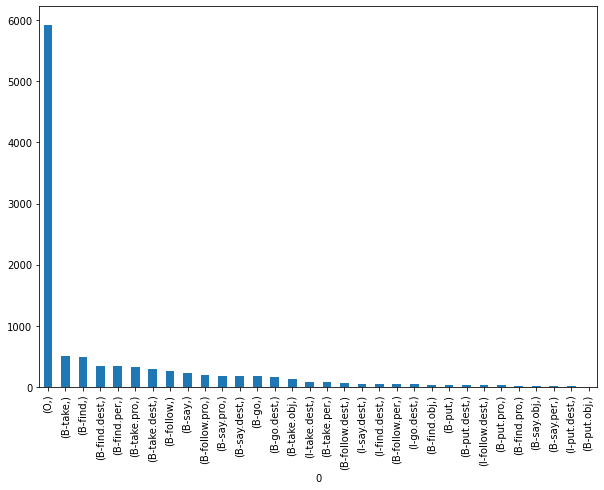

In [26]:
label_df = pd.DataFrame( x for seq in seq_out for x in seq)#seq_out,columns = [str(i) for i in range(max_len)])
display(label_df.head(5))
label_df.value_counts(subset=None, dropna = True).plot(kind = 'bar', figsize = (10,7))
#.plot(kind = 'hist')

Model: 
https://huggingface.co/databuzzword/JointBERT-atis/tree/main

https://huggingface.co/databuzzword/JointBERT-snips

In [28]:
!pip install pipeline

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [15]:
from transformers import AutoTokenizer, JointBERT

tokenizer = AutoTokenizer.from_pretrained("databuzzword/JointBERT-snips")

model = JointBERT.from_pretrained("databuzzword/JointBERT-snips")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


ImportError: cannot import name 'JointBERT' from 'transformers' (/home/crossing/.local/lib/python3.8/site-packages/transformers/__init__.py)

In [16]:
from transformers import BertTokenizer#, BertForMaskedLM
import torch
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [21]:
import torch.nn as nn


class IntentClassifier(nn.Module):
    def __init__(self, input_dim, num_intent_labels, dropout_rate=0.):
        super(IntentClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, num_intent_labels)

    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)


class SlotClassifier(nn.Module):
    def __init__(self, input_dim, num_slot_labels, dropout_rate=0.):
        super(SlotClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, num_slot_labels)

    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)

In [24]:
import torch
import torch.nn as nn
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel, BertConfig
#from torchcrf import CRF
#from .module import IntentClassifier, SlotClassifier


class JointBERT(BertPreTrainedModel):
    def __init__(self, config, args, intent_label_lst, slot_label_lst):
        super(JointBERT, self).__init__(config)
        self.args = args
        self.num_intent_labels = len(intent_label_lst)
        self.num_slot_labels = len(slot_label_lst)
        self.bert = BertModel(config=config)  # Load pretrained bert

        self.intent_classifier = IntentClassifier(config.hidden_size, self.num_intent_labels, args.dropout_rate)
        self.slot_classifier = SlotClassifier(config.hidden_size, self.num_slot_labels, args.dropout_rate)

        #if args.use_crf:
            #self.crf = CRF(num_tags=self.num_slot_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, token_type_ids, intent_label_ids, slot_labels_ids):
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                            token_type_ids=token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        sequence_output = outputs[0]
        pooled_output = outputs[1]  # [CLS]

        intent_logits = self.intent_classifier(pooled_output)
        slot_logits = self.slot_classifier(sequence_output)

        total_loss = 0
        # 1. Intent Softmax
        if intent_label_ids is not None:
            if self.num_intent_labels == 1:
                intent_loss_fct = nn.MSELoss()
                intent_loss = intent_loss_fct(intent_logits.view(-1), intent_label_ids.view(-1))
            else:
                intent_loss_fct = nn.CrossEntropyLoss()
                intent_loss = intent_loss_fct(intent_logits.view(-1, self.num_intent_labels), intent_label_ids.view(-1))
            total_loss += intent_loss

        # 2. Slot Softmax
        if slot_labels_ids is not None:
            if self.args.use_crf:
                slot_loss = self.crf(slot_logits, slot_labels_ids, mask=attention_mask.byte(), reduction='mean')
                slot_loss = -1 * slot_loss  # negative log-likelihood
            else:
                slot_loss_fct = nn.CrossEntropyLoss(ignore_index=self.args.ignore_index)
                # Only keep active parts of the loss
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = slot_logits.view(-1, self.num_slot_labels)[active_loss]
                    active_labels = slot_labels_ids.view(-1)[active_loss]
                    slot_loss = slot_loss_fct(active_logits, active_labels)
                else:
                    slot_loss = slot_loss_fct(slot_logits.view(-1, self.num_slot_labels), slot_labels_ids.view(-1))
            total_loss += self.args.slot_loss_coef * slot_loss

        outputs = ((intent_logits, slot_logits),) + outputs[2:]  # add hidden states and attention if they are here

        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions) # Logits is a tuple of intent and slot logits

In [47]:
# config, args, intent_label_lst, slot_label_lst

# config 
# args 

ser = label_df.value_counts(subset=None, dropna = True)

intent_label_lst = [label[0] for label in ser.index if '.' not in label[0]]
slot_label_lst = [label[0] for label in ser.index if '.' in label[0]]

print('intent_label_lst: \n',intent_label_lst,'\n')
print('slot_label_lst: \n',slot_label_lst)
# intent_label_lst = 
# slot_label_lst = 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
J = JointBERT(config, args, intent_label_lst, slot_label_lst).to(device)

intent_label_lst: 
 ['O', 'B-take', 'B-find', 'B-follow', 'B-say', 'B-go', 'B-put'] 

slot_label_lst: 
 ['B-find.dest', 'B-find.per', 'B-take.pro', 'B-take.dest', 'B-follow.pro', 'B-say.pro', 'B-say.dest', 'B-go.dest', 'B-take.obj', 'I-take.dest', 'B-take.per', 'B-follow.dest', 'I-say.dest', 'I-find.dest', 'B-follow.per', 'I-go.dest', 'B-find.obj', 'B-put.dest', 'I-follow.dest', 'B-put.pro', 'B-find.pro', 'B-say.obj', 'B-say.per', 'I-put.dest', 'B-put.obj']


NameError: name 'config' is not defined